### Build basic PyTorch neural network
We will use the Iris dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Create a model class
class Model(nn.Module):

    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        # 1) How many layers are there?
        # Input layer (4 feats) --> h1 (N neurons) --> h2 (M neurons) --> output (3 classes)
        ## h1 and h2 are arbitrary choices of # of neurons per layer
        super().__init__()  # Instantiates nn.Module class
        self.fc1 = nn.Linear(in_features, h1)  # Layer 1 is fully connected to input features
        self.fc2 = nn.Linear(h1, h2)  # Layer 2 is fully connected to layer 1
        self.out = nn.Linear(h2, out_features)

    def forward(self, x):
        # 2) Set our propagation method that propagates forward
        x = F.relu(self.fc1(x))  # rectified linear unit as our activation function
        x = F.relu(self.fc2(x))
        x = F.relu(self.out(x))
        return x

In [3]:
# Instantiate the model
model = Model()

In [4]:
# Explore dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


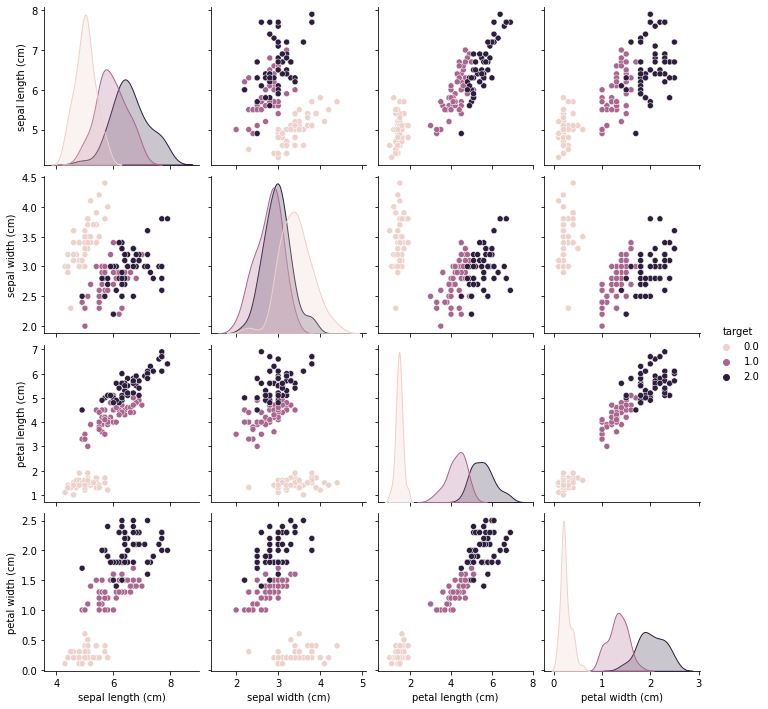

In [6]:
sns.pairplot(df, hue='target')

In [7]:
# Train/test split
target_col = 'target'
feat_cols = [el for el in df.columns if el != target_col]
X = df[feat_cols].values
y = df[target_col].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [8]:
# Finalize model definition
# Generally we want to turn the target values into dummies. By using CrossEntropyLoss, we don't have to
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)>

In [9]:
epochs = 100
losses = []

for i in range(epochs):
    # Propagate fwd thru model and get prediction
    y_pred = model.forward(X_train)
    
    # Quantify loss/error
    loss = criterion(y_pred, y_train)
    losses.append(loss)

    if i%10 == 0:
        print(f'Epoch: {i}, Loss: {loss}')

    # Backpropagate
    optimizer.zero_grad()  # Look for where gradient is zero (looking for minimums)
    loss.backward()
    optimizer.step()  # Update hyperparams

Epoch: 0, Loss: 1.069098949432373
Epoch: 10, Loss: 0.7009291648864746
Epoch: 20, Loss: 0.46735748648643494
Epoch: 30, Loss: 0.3017725646495819
Epoch: 40, Loss: 0.16221864521503448
Epoch: 50, Loss: 0.09502945095300674
Epoch: 60, Loss: 0.07366406917572021
Epoch: 70, Loss: 0.06603505462408066
Epoch: 80, Loss: 0.06221983954310417
Epoch: 90, Loss: 0.059643205255270004


In [10]:
losses

[tensor(1.0691, grad_fn=<NllLossBackward0>),
 tensor(1.0097, grad_fn=<NllLossBackward0>),
 tensor(0.9643, grad_fn=<NllLossBackward0>),
 tensor(0.9264, grad_fn=<NllLossBackward0>),
 tensor(0.8917, grad_fn=<NllLossBackward0>),
 tensor(0.8580, grad_fn=<NllLossBackward0>),
 tensor(0.8241, grad_fn=<NllLossBackward0>),
 tensor(0.7919, grad_fn=<NllLossBackward0>),
 tensor(0.7607, grad_fn=<NllLossBackward0>),
 tensor(0.7299, grad_fn=<NllLossBackward0>),
 tensor(0.7009, grad_fn=<NllLossBackward0>),
 tensor(0.6728, grad_fn=<NllLossBackward0>),
 tensor(0.6453, grad_fn=<NllLossBackward0>),
 tensor(0.6187, grad_fn=<NllLossBackward0>),
 tensor(0.5938, grad_fn=<NllLossBackward0>),
 tensor(0.5701, grad_fn=<NllLossBackward0>),
 tensor(0.5476, grad_fn=<NllLossBackward0>),
 tensor(0.5262, grad_fn=<NllLossBackward0>),
 tensor(0.5055, grad_fn=<NllLossBackward0>),
 tensor(0.4859, grad_fn=<NllLossBackward0>),
 tensor(0.4674, grad_fn=<NllLossBackward0>),
 tensor(0.4495, grad_fn=<NllLossBackward0>),
 tensor(0.

Text(0.5, 0, 'Epoch')

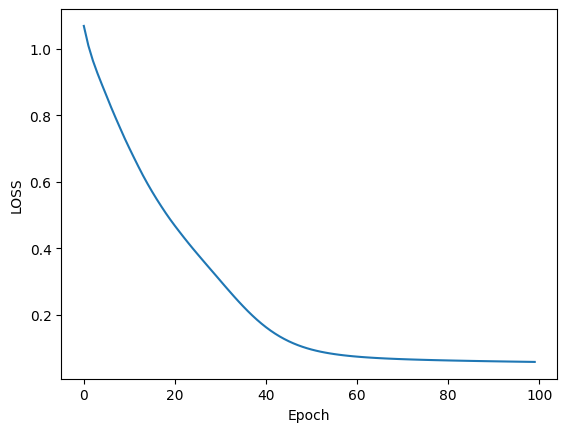

In [11]:
plt.plot(range(epochs), [el.item() for el in losses])
plt.ylabel('LOSS')
plt.xlabel('Epoch')

In [12]:
# Validate model on test set

# Tell pytorch to not worry about backprop - reduces memory usage
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)

loss
# It's good that our testing loss is similar to our training loss. This indicates we're not overfitting

tensor(0.0538)

In [19]:
# How many flowers did we classify correctly?
correct = 0

with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1}) Pred: {str(y_val)} \t Actual: {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'Total correct: {correct}')

1) Pred: tensor([0.0000, 8.2809, 2.4981]) 	 Actual: 1
2) Pred: tensor([15.0609,  7.6718,  0.0000]) 	 Actual: 0
3) Pred: tensor([ 0.0000,  7.1920, 20.4049]) 	 Actual: 2
4) Pred: tensor([0.0000, 8.0806, 3.5452]) 	 Actual: 1
5) Pred: tensor([0.0000, 8.7527, 2.7792]) 	 Actual: 1
6) Pred: tensor([13.8624,  7.2462,  0.0000]) 	 Actual: 0
7) Pred: tensor([2.4381, 8.2226, 0.0000]) 	 Actual: 1
8) Pred: tensor([ 0.0000,  7.9252, 10.7711]) 	 Actual: 2
9) Pred: tensor([0.0000, 7.4136, 6.3444]) 	 Actual: 1
10) Pred: tensor([1.4192, 8.3229, 0.0000]) 	 Actual: 1
11) Pred: tensor([0.0000, 7.9665, 8.9134]) 	 Actual: 2
12) Pred: tensor([13.3124,  6.5744,  0.0000]) 	 Actual: 0
13) Pred: tensor([15.1710,  7.1499,  0.0000]) 	 Actual: 0
14) Pred: tensor([13.4709,  6.7359,  0.0000]) 	 Actual: 0
15) Pred: tensor([14.8059,  7.1873,  0.0000]) 	 Actual: 0
16) Pred: tensor([0.0000, 8.6572, 2.9018]) 	 Actual: 1
17) Pred: tensor([ 0.0000,  7.0053, 15.8306]) 	 Actual: 2
18) Pred: tensor([0.9653, 8.0583, 0.0000]) 	 Ac

In [20]:
# Save trained model to file
# Saving state_dict() only saves weights and biases
# Save the entire model, which includes the Model() class by doing torch.save(model, '<name>.pkl')
torch.save(model.state_dict(), 'ann_iris_classification.pt')

In [21]:
# Create new model from previously saved model
# This assumes we still have access to the Model() class!
new_model = Model()
new_model.load_state_dict(torch.load('ann_iris_classification.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [25]:
# How to use model on brand new data!
mystery_iris = torch.tensor([5.6, 3.7, 2.2, 0.5])  # This should be setosa (class 0)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


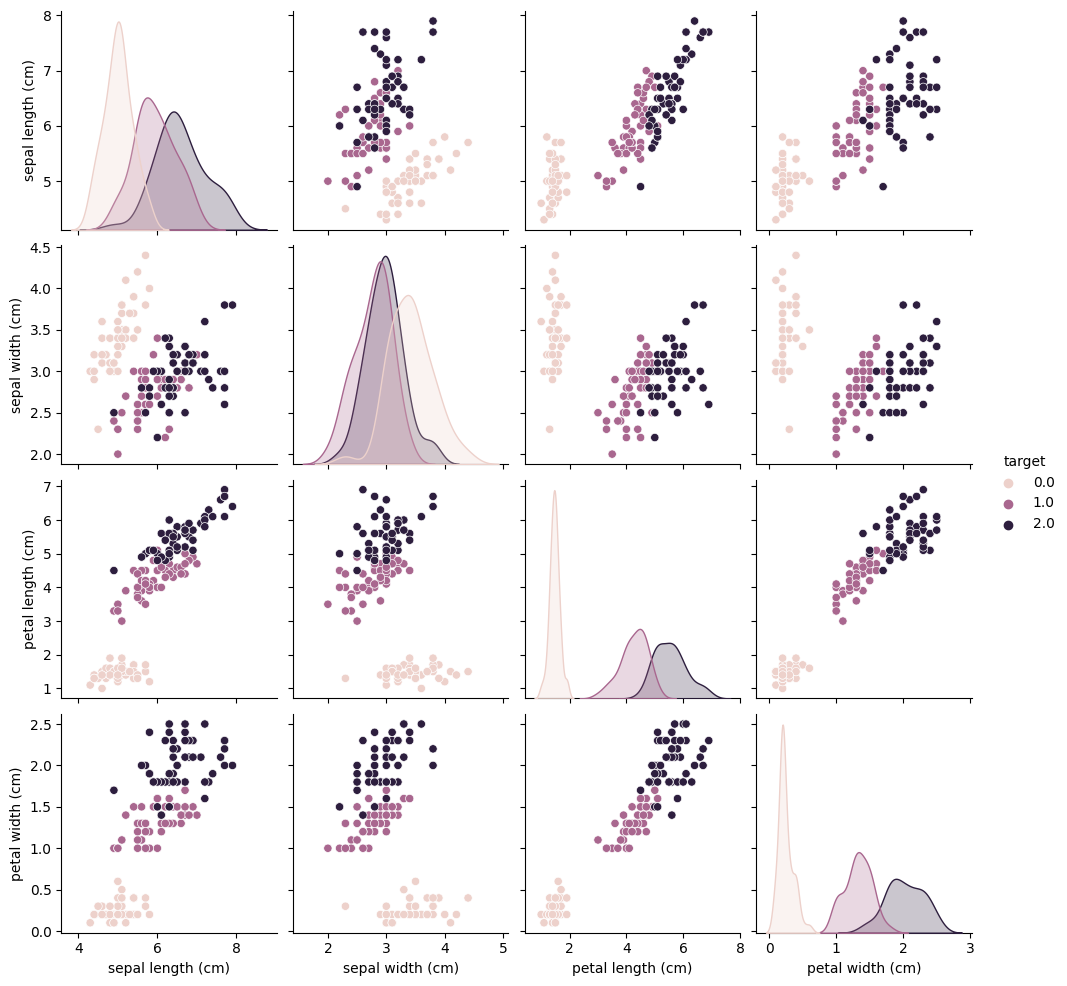

In [26]:
sns.pairplot(df, hue='target')
# [5.6, 3.7, 2.2, 0.5]

In [27]:
with torch.no_grad():
    print(new_model(mystery_iris))

tensor([12.8398,  7.9420,  0.0000])


: 

In [ ]:
# We correctly predict class 0, iris setosa, for the mystery_iris point!